In [1]:
import sys
sys.path.append("../source")

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pylab
from tqdm import trange
import scipy
import scipy.stats as stats
from scipy.stats import bernoulli
import matplotlib as mp
from numba import njit
from project_lib import *
import pandas as pd

In [14]:
def init_expon_distrib_consensus_data(consensus_data, experiment, N, alpha, R):
    if not ((consensus_data['N'] == N) 
            & (consensus_data['alpha'] == alpha) 
            & (round(consensus_data['eps'],2) == round(R,2))
            ).any():
        consensus_data.at[experiment, "N"] = N
        consensus_data.at[experiment, "alpha"] = alpha
        consensus_data.at[experiment, "eps"] = round(R,2)
        consensus_data.at[experiment, "consensus_x"] = 0
        consensus_data.at[experiment, "consensus_y"] = 0
        consensus_data.at[experiment, "consensus_probabity"] =0
        consensus_data.at[experiment, "simulation_time"] =0
        consensus_data.at[experiment, "simulation_count"] = 0

def update_expon_distrib_consensus_data(consensus_data, experiment, res_arr_fast):
    consensus_data.at[experiment, "consensus_x"] += res_arr_fast[-1, 0, 0]
    consensus_data.at[experiment, "consensus_y"] += res_arr_fast[-1, 0, 1]
    consensus_data.at[experiment, "consensus_probabity"] +=1
    consensus_data.at[experiment, "simulation_time"] +=res_arr_fast.shape[0]
    

dtypes = {
    'N': np.int64,
    'alpha': np.float64,
    'eps': np.float64,
    'consensus_x': np.float64,
    'consensus_y': np.float64,
    'consensus_probabity': np.float64,
    'simulation_time': np.int64,
    'simulation_count': np.int64
}
consensus_data = pd.DataFrame(columns=["N", "alpha", "eps", "consensus_x", "consensus_y","consensus_probabity", "simulation_time"], dtype=object)
consensus_data

,N,alpha,eps,consensus_x,consensus_y,consensus_probabity,simulation_time


In [ ]:
consensus_data = pd.read_csv('expon_distrib_consensus_data.csv', sep=";", dtype=dtypes)
consensus_data

Мы хотим задать свое распределение - ограничить экспоненциальное отрезком [0,1] и отнормировать

In [5]:
class MyRandomVariableClass(stats.rv_continuous):
    def __init__(self, alpha, xtol=1e-14, seed=None):
        self.alpha = alpha
        super().__init__(a=0, xtol=xtol, seed=seed)

    def _cdf(self, x):
        # alpha = 1
        # return -np.exp(-x*self.alpha) + 1 + np.exp(-self.alpha)*x
        return (1-np.exp(-x*self.alpha))/(1-np.exp(-self.alpha))
    
    def _pdf(self, x):
        # alpha = 1
        # return np.exp(-x*self.alpha)*self.alpha + np.exp(-self.alpha)
        return self.alpha*np.exp(-x*self.alpha)/(1-np.exp(-self.alpha))

    

Проверка

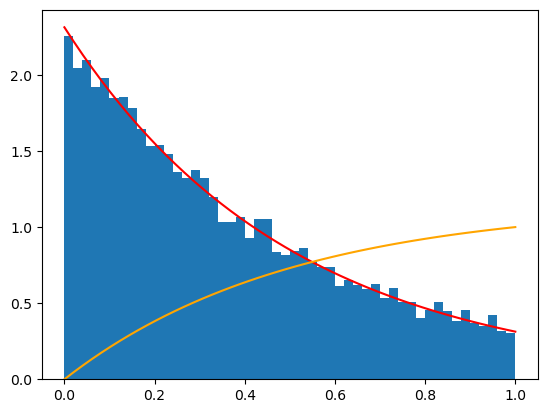

In [18]:

alpha = 2
my_rv1 = MyRandomVariableClass(alpha)

# sample distribution
samples = my_rv1.rvs(size = 10000)

# plot histogram of samples
fig, ax1 = plt.subplots()
ax1.hist(list(samples), bins=50, density=True)

# plot PDF and CDF of distribution
pts = np.linspace(0, 1)
ax1.plot(pts, my_rv1.pdf(pts), color='red')
ax1.plot(pts, my_rv1.cdf(pts), color='orange')
# ax1.plot(pts, np.exp(-pts*alpha)*alpha + np.exp(-alpha), color='green')


plt.show()

In [8]:
R = 0.2  # радиус доверия
eps = 1e-4  # допустимая точность
n = 50  # количество агентов по одной оси
N = n

In [9]:
R_array = [round(i,2)for i in np.arange(0.15, 1.01, 0.05)]
params_array =  np.arange(0.5, 5.1, 0.5)
params_array

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

In [68]:
import numpy as np
def expon_distrib_a2Esigma(alpha):
    e2ma = np.exp(-alpha)
    E = 1 / (1 - e2ma) * (-e2ma - 1/alpha * e2ma + 1/alpha)
    Ex2 = (1 / (1 - e2ma)) * (-e2ma - 2.0/alpha * e2ma - 2.0/(alpha**2) * e2ma + 2.0/(alpha**2))
    return E, Ex2 - E**2

In [54]:
my_rv1.mean(), my_rv1.std()

(0.3434823572503395, 0.26264916668137156)

In [59]:
E, D = expon_distrib_a2Esigma(alpha)
E, D

(0.3434823572503344, 0.2626491666813781)

In [11]:
experiments = 100

In [16]:
experiment = 0 ##consensus_data.index[-1] +1

simulation_func = HK_2D_sim_fast
count_consensus = 0
CONSENSUS_BORDER = 5

for i in range (len(params_array)):
    alpha = params_array[i]
    my_rv = MyRandomVariableClass(alpha)
    for R in R_array:
        init_expon_distrib_consensus_data(consensus_data, experiment, N, alpha, R)
        if count_consensus>=CONSENSUS_BORDER: simulation_func=HK_2D_sim
        print(f"N:{N} R:{R} a:{alpha} func:{simulation_func.__name__} count:{count_consensus}")

        for i in trange(experiments):
            x0 = my_rv.rvs(size = (N,2))
            res_arr_fast, check_fast = simulation_func(x0, R, R * 1e-3, 1000)
            if check_fast:
                cluster_of_agent, cluster_sizes = caln_n_clusters(res_arr_fast[-1, :, :], R)
                experiment = consensus_data[
                    ((consensus_data['N'] == N) 
                    & (consensus_data['alpha'] == alpha) 
                    & (round(consensus_data['eps'],2) == round(R,2)))].index[0]
                consensus_data.at[experiment, "simulation_count"] +=1
                if len(cluster_sizes)==1:
                    # we have consensus
                    count_consensus+=1
                    update_expon_distrib_consensus_data(consensus_data, experiment, res_arr_fast)
            else:
                draw_HK_2D_simulation(res_arr_fast, 'plasma')
        experiment = consensus_data.index[-1] +1

N:50 R:0.15 a:0.5 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:04<00:00, 21.33it/s]


N:50 R:0.2 a:0.5 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:04<00:00, 22.76it/s]


N:50 R:0.25 a:0.5 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:04<00:00, 22.36it/s]


N:50 R:0.3 a:0.5 func:HK_2D_sim_fast count:0


100%|██████████| 100/100 [00:04<00:00, 22.76it/s]


N:50 R:0.35 a:0.5 func:HK_2D_sim count:31


100%|██████████| 100/100 [00:04<00:00, 20.13it/s]


N:50 R:0.4 a:0.5 func:HK_2D_sim count:109


100%|██████████| 100/100 [00:04<00:00, 21.13it/s]


N:50 R:0.45 a:0.5 func:HK_2D_sim count:206


100%|██████████| 100/100 [00:04<00:00, 21.46it/s]


N:50 R:0.5 a:0.5 func:HK_2D_sim count:306


100%|██████████| 100/100 [00:04<00:00, 22.34it/s]


N:50 R:0.55 a:0.5 func:HK_2D_sim count:406


100%|██████████| 100/100 [00:04<00:00, 21.76it/s]


N:50 R:0.6 a:0.5 func:HK_2D_sim count:506


100%|██████████| 100/100 [00:04<00:00, 22.43it/s]


N:50 R:0.65 a:0.5 func:HK_2D_sim count:606


100%|██████████| 100/100 [00:04<00:00, 22.12it/s]


N:50 R:0.7 a:0.5 func:HK_2D_sim count:706


100%|██████████| 100/100 [00:04<00:00, 22.75it/s]


N:50 R:0.75 a:0.5 func:HK_2D_sim count:806


100%|██████████| 100/100 [00:04<00:00, 22.41it/s]


N:50 R:0.8 a:0.5 func:HK_2D_sim count:906


100%|██████████| 100/100 [00:04<00:00, 22.67it/s]


N:50 R:0.85 a:0.5 func:HK_2D_sim count:1006


100%|██████████| 100/100 [00:04<00:00, 22.50it/s]


N:50 R:0.9 a:0.5 func:HK_2D_sim count:1106


100%|██████████| 100/100 [00:04<00:00, 22.37it/s]


N:50 R:0.95 a:0.5 func:HK_2D_sim count:1206


100%|██████████| 100/100 [00:04<00:00, 22.14it/s]


N:50 R:1.0 a:0.5 func:HK_2D_sim count:1306


100%|██████████| 100/100 [00:04<00:00, 22.69it/s]


N:50 R:0.15 a:1.0 func:HK_2D_sim count:1406


100%|██████████| 100/100 [00:05<00:00, 19.58it/s]


N:50 R:0.2 a:1.0 func:HK_2D_sim count:1406


100%|██████████| 100/100 [00:05<00:00, 19.60it/s]


N:50 R:0.25 a:1.0 func:HK_2D_sim count:1406


100%|██████████| 100/100 [00:05<00:00, 19.47it/s]


N:50 R:0.3 a:1.0 func:HK_2D_sim count:1406


100%|██████████| 100/100 [00:05<00:00, 19.42it/s]


N:50 R:0.35 a:1.0 func:HK_2D_sim count:1420


100%|██████████| 100/100 [00:05<00:00, 19.98it/s]


N:50 R:0.4 a:1.0 func:HK_2D_sim count:1489


100%|██████████| 100/100 [00:05<00:00, 19.58it/s]


N:50 R:0.45 a:1.0 func:HK_2D_sim count:1583


100%|██████████| 100/100 [00:04<00:00, 20.26it/s]


N:50 R:0.5 a:1.0 func:HK_2D_sim count:1681


100%|██████████| 100/100 [00:05<00:00, 19.99it/s]


N:50 R:0.55 a:1.0 func:HK_2D_sim count:1781


100%|██████████| 100/100 [00:05<00:00, 19.78it/s]


N:50 R:0.6 a:1.0 func:HK_2D_sim count:1881


100%|██████████| 100/100 [00:05<00:00, 19.76it/s]


N:50 R:0.65 a:1.0 func:HK_2D_sim count:1981


100%|██████████| 100/100 [00:04<00:00, 20.51it/s]


N:50 R:0.7 a:1.0 func:HK_2D_sim count:2081


100%|██████████| 100/100 [00:04<00:00, 20.33it/s]


N:50 R:0.75 a:1.0 func:HK_2D_sim count:2181


100%|██████████| 100/100 [00:04<00:00, 20.47it/s]


N:50 R:0.8 a:1.0 func:HK_2D_sim count:2281


100%|██████████| 100/100 [00:04<00:00, 20.40it/s]


N:50 R:0.85 a:1.0 func:HK_2D_sim count:2381


100%|██████████| 100/100 [00:04<00:00, 20.22it/s]


N:50 R:0.9 a:1.0 func:HK_2D_sim count:2481


100%|██████████| 100/100 [00:04<00:00, 20.18it/s]


N:50 R:0.95 a:1.0 func:HK_2D_sim count:2581


100%|██████████| 100/100 [00:04<00:00, 20.47it/s]


N:50 R:1.0 a:1.0 func:HK_2D_sim count:2681


100%|██████████| 100/100 [00:04<00:00, 20.49it/s]


N:50 R:0.15 a:1.5 func:HK_2D_sim count:2781


100%|██████████| 100/100 [00:05<00:00, 18.48it/s]


N:50 R:0.2 a:1.5 func:HK_2D_sim count:2781


100%|██████████| 100/100 [00:05<00:00, 18.77it/s]


N:50 R:0.25 a:1.5 func:HK_2D_sim count:2781


100%|██████████| 100/100 [00:05<00:00, 18.40it/s]


N:50 R:0.3 a:1.5 func:HK_2D_sim count:2781


100%|██████████| 100/100 [00:05<00:00, 18.47it/s]


N:50 R:0.35 a:1.5 func:HK_2D_sim count:2798


100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


N:50 R:0.4 a:1.5 func:HK_2D_sim count:2867


100%|██████████| 100/100 [00:05<00:00, 18.11it/s]


N:50 R:0.45 a:1.5 func:HK_2D_sim count:2954


100%|██████████| 100/100 [00:05<00:00, 18.08it/s]


N:50 R:0.5 a:1.5 func:HK_2D_sim count:3049


100%|██████████| 100/100 [00:05<00:00, 18.39it/s]


N:50 R:0.55 a:1.5 func:HK_2D_sim count:3148


100%|██████████| 100/100 [00:05<00:00, 18.26it/s]


N:50 R:0.6 a:1.5 func:HK_2D_sim count:3248


100%|██████████| 100/100 [00:05<00:00, 18.64it/s]


N:50 R:0.65 a:1.5 func:HK_2D_sim count:3348


100%|██████████| 100/100 [00:05<00:00, 18.66it/s]


N:50 R:0.7 a:1.5 func:HK_2D_sim count:3448


100%|██████████| 100/100 [00:05<00:00, 18.76it/s]


N:50 R:0.75 a:1.5 func:HK_2D_sim count:3548


100%|██████████| 100/100 [00:05<00:00, 18.20it/s]


N:50 R:0.8 a:1.5 func:HK_2D_sim count:3648


100%|██████████| 100/100 [00:05<00:00, 18.57it/s]


N:50 R:0.85 a:1.5 func:HK_2D_sim count:3748


100%|██████████| 100/100 [00:05<00:00, 18.34it/s]


N:50 R:0.9 a:1.5 func:HK_2D_sim count:3848


100%|██████████| 100/100 [00:05<00:00, 17.67it/s]


N:50 R:0.95 a:1.5 func:HK_2D_sim count:3948


100%|██████████| 100/100 [00:05<00:00, 18.60it/s]


N:50 R:1.0 a:1.5 func:HK_2D_sim count:4048


100%|██████████| 100/100 [00:05<00:00, 18.52it/s]


N:50 R:0.15 a:2.0 func:HK_2D_sim count:4148


100%|██████████| 100/100 [00:05<00:00, 16.98it/s]


N:50 R:0.2 a:2.0 func:HK_2D_sim count:4148


100%|██████████| 100/100 [00:05<00:00, 17.13it/s]


N:50 R:0.25 a:2.0 func:HK_2D_sim count:4148


100%|██████████| 100/100 [00:05<00:00, 17.30it/s]


N:50 R:0.3 a:2.0 func:HK_2D_sim count:4148


100%|██████████| 100/100 [00:05<00:00, 17.13it/s]


N:50 R:0.35 a:2.0 func:HK_2D_sim count:4162


100%|██████████| 100/100 [00:05<00:00, 17.14it/s]


N:50 R:0.4 a:2.0 func:HK_2D_sim count:4210


100%|██████████| 100/100 [00:05<00:00, 17.34it/s]


N:50 R:0.45 a:2.0 func:HK_2D_sim count:4300


100%|██████████| 100/100 [00:05<00:00, 17.15it/s]


N:50 R:0.5 a:2.0 func:HK_2D_sim count:4398


100%|██████████| 100/100 [00:05<00:00, 17.66it/s]


N:50 R:0.55 a:2.0 func:HK_2D_sim count:4497


100%|██████████| 100/100 [00:05<00:00, 17.95it/s]


N:50 R:0.6 a:2.0 func:HK_2D_sim count:4597


100%|██████████| 100/100 [00:05<00:00, 17.86it/s]


N:50 R:0.65 a:2.0 func:HK_2D_sim count:4697


100%|██████████| 100/100 [00:05<00:00, 17.88it/s]


N:50 R:0.7 a:2.0 func:HK_2D_sim count:4797


100%|██████████| 100/100 [00:05<00:00, 17.89it/s]


N:50 R:0.75 a:2.0 func:HK_2D_sim count:4897


100%|██████████| 100/100 [00:05<00:00, 17.91it/s]


N:50 R:0.8 a:2.0 func:HK_2D_sim count:4997


100%|██████████| 100/100 [00:05<00:00, 17.90it/s]


N:50 R:0.85 a:2.0 func:HK_2D_sim count:5097


100%|██████████| 100/100 [00:05<00:00, 17.79it/s]


N:50 R:0.9 a:2.0 func:HK_2D_sim count:5197


100%|██████████| 100/100 [00:05<00:00, 17.79it/s]


N:50 R:0.95 a:2.0 func:HK_2D_sim count:5297


100%|██████████| 100/100 [00:05<00:00, 17.63it/s]


N:50 R:1.0 a:2.0 func:HK_2D_sim count:5397


100%|██████████| 100/100 [00:05<00:00, 17.74it/s]


N:50 R:0.15 a:2.5 func:HK_2D_sim count:5497


100%|██████████| 100/100 [00:05<00:00, 16.90it/s]


N:50 R:0.2 a:2.5 func:HK_2D_sim count:5497


100%|██████████| 100/100 [00:05<00:00, 16.90it/s]


N:50 R:0.25 a:2.5 func:HK_2D_sim count:5497


100%|██████████| 100/100 [00:05<00:00, 17.10it/s]


N:50 R:0.3 a:2.5 func:HK_2D_sim count:5499


100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


N:50 R:0.35 a:2.5 func:HK_2D_sim count:5518


100%|██████████| 100/100 [00:05<00:00, 17.01it/s]


N:50 R:0.4 a:2.5 func:HK_2D_sim count:5574


100%|██████████| 100/100 [00:05<00:00, 17.19it/s]


N:50 R:0.45 a:2.5 func:HK_2D_sim count:5660


100%|██████████| 100/100 [00:05<00:00, 17.08it/s]


N:50 R:0.5 a:2.5 func:HK_2D_sim count:5752


100%|██████████| 100/100 [00:05<00:00, 17.12it/s]


N:50 R:0.55 a:2.5 func:HK_2D_sim count:5850


100%|██████████| 100/100 [00:05<00:00, 17.34it/s]


N:50 R:0.6 a:2.5 func:HK_2D_sim count:5950


100%|██████████| 100/100 [00:05<00:00, 17.16it/s]


N:50 R:0.65 a:2.5 func:HK_2D_sim count:6050


100%|██████████| 100/100 [00:05<00:00, 17.10it/s]


N:50 R:0.7 a:2.5 func:HK_2D_sim count:6150


100%|██████████| 100/100 [00:05<00:00, 17.51it/s]


N:50 R:0.75 a:2.5 func:HK_2D_sim count:6250


100%|██████████| 100/100 [00:05<00:00, 17.30it/s]


N:50 R:0.8 a:2.5 func:HK_2D_sim count:6350


100%|██████████| 100/100 [00:05<00:00, 17.19it/s]


N:50 R:0.85 a:2.5 func:HK_2D_sim count:6450


100%|██████████| 100/100 [00:05<00:00, 17.49it/s]


N:50 R:0.9 a:2.5 func:HK_2D_sim count:6550


100%|██████████| 100/100 [00:05<00:00, 17.51it/s]


N:50 R:0.95 a:2.5 func:HK_2D_sim count:6650


100%|██████████| 100/100 [00:05<00:00, 17.46it/s]


N:50 R:1.0 a:2.5 func:HK_2D_sim count:6750


100%|██████████| 100/100 [00:05<00:00, 17.53it/s]


N:50 R:0.15 a:3.0 func:HK_2D_sim count:6850


100%|██████████| 100/100 [00:06<00:00, 16.64it/s]


N:50 R:0.2 a:3.0 func:HK_2D_sim count:6850


100%|██████████| 100/100 [00:06<00:00, 16.55it/s]


N:50 R:0.25 a:3.0 func:HK_2D_sim count:6850


100%|██████████| 100/100 [00:05<00:00, 16.88it/s]


N:50 R:0.3 a:3.0 func:HK_2D_sim count:6851


100%|██████████| 100/100 [00:05<00:00, 16.72it/s]


N:50 R:0.35 a:3.0 func:HK_2D_sim count:6860


100%|██████████| 100/100 [00:05<00:00, 16.85it/s]


N:50 R:0.4 a:3.0 func:HK_2D_sim count:6904


100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


N:50 R:0.45 a:3.0 func:HK_2D_sim count:6979


100%|██████████| 100/100 [00:05<00:00, 17.33it/s]


N:50 R:0.5 a:3.0 func:HK_2D_sim count:7068


100%|██████████| 100/100 [00:05<00:00, 17.31it/s]


N:50 R:0.55 a:3.0 func:HK_2D_sim count:7166


100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


N:50 R:0.6 a:3.0 func:HK_2D_sim count:7265


100%|██████████| 100/100 [00:05<00:00, 17.45it/s]


N:50 R:0.65 a:3.0 func:HK_2D_sim count:7364


100%|██████████| 100/100 [00:05<00:00, 17.50it/s]


N:50 R:0.7 a:3.0 func:HK_2D_sim count:7464


100%|██████████| 100/100 [00:05<00:00, 17.48it/s]


N:50 R:0.75 a:3.0 func:HK_2D_sim count:7564


100%|██████████| 100/100 [00:05<00:00, 17.47it/s]


N:50 R:0.8 a:3.0 func:HK_2D_sim count:7664


100%|██████████| 100/100 [00:05<00:00, 17.18it/s]


N:50 R:0.85 a:3.0 func:HK_2D_sim count:7764


100%|██████████| 100/100 [00:05<00:00, 17.52it/s]


N:50 R:0.9 a:3.0 func:HK_2D_sim count:7864


100%|██████████| 100/100 [00:05<00:00, 17.61it/s]


N:50 R:0.95 a:3.0 func:HK_2D_sim count:7964


100%|██████████| 100/100 [00:05<00:00, 17.44it/s]


N:50 R:1.0 a:3.0 func:HK_2D_sim count:8064


100%|██████████| 100/100 [00:05<00:00, 17.40it/s]


N:50 R:0.15 a:3.5 func:HK_2D_sim count:8164


100%|██████████| 100/100 [00:06<00:00, 16.63it/s]


N:50 R:0.2 a:3.5 func:HK_2D_sim count:8164


100%|██████████| 100/100 [00:06<00:00, 16.43it/s]


N:50 R:0.25 a:3.5 func:HK_2D_sim count:8164


100%|██████████| 100/100 [00:05<00:00, 16.70it/s]


N:50 R:0.3 a:3.5 func:HK_2D_sim count:8165


100%|██████████| 100/100 [00:06<00:00, 16.40it/s]


N:50 R:0.35 a:3.5 func:HK_2D_sim count:8175


100%|██████████| 100/100 [00:06<00:00, 16.58it/s]


N:50 R:0.4 a:3.5 func:HK_2D_sim count:8214


100%|██████████| 100/100 [00:06<00:00, 16.52it/s]


N:50 R:0.45 a:3.5 func:HK_2D_sim count:8286


100%|██████████| 100/100 [00:05<00:00, 16.87it/s]


N:50 R:0.5 a:3.5 func:HK_2D_sim count:8376


100%|██████████| 100/100 [00:05<00:00, 16.80it/s]


N:50 R:0.55 a:3.5 func:HK_2D_sim count:8473


100%|██████████| 100/100 [00:05<00:00, 16.87it/s]


N:50 R:0.6 a:3.5 func:HK_2D_sim count:8572


100%|██████████| 100/100 [00:05<00:00, 16.81it/s]


N:50 R:0.65 a:3.5 func:HK_2D_sim count:8671


100%|██████████| 100/100 [00:05<00:00, 16.80it/s]


N:50 R:0.7 a:3.5 func:HK_2D_sim count:8771


100%|██████████| 100/100 [00:05<00:00, 16.71it/s]


N:50 R:0.75 a:3.5 func:HK_2D_sim count:8871


100%|██████████| 100/100 [00:05<00:00, 16.88it/s]


N:50 R:0.8 a:3.5 func:HK_2D_sim count:8971


100%|██████████| 100/100 [00:06<00:00, 16.60it/s]


N:50 R:0.85 a:3.5 func:HK_2D_sim count:9071


100%|██████████| 100/100 [00:05<00:00, 16.84it/s]


N:50 R:0.9 a:3.5 func:HK_2D_sim count:9171


100%|██████████| 100/100 [00:05<00:00, 16.89it/s]


N:50 R:0.95 a:3.5 func:HK_2D_sim count:9271


100%|██████████| 100/100 [00:05<00:00, 16.82it/s]


N:50 R:1.0 a:3.5 func:HK_2D_sim count:9371


100%|██████████| 100/100 [00:05<00:00, 16.74it/s]


N:50 R:0.15 a:4.0 func:HK_2D_sim count:9471


100%|██████████| 100/100 [00:06<00:00, 16.22it/s]


N:50 R:0.2 a:4.0 func:HK_2D_sim count:9471


100%|██████████| 100/100 [00:06<00:00, 16.27it/s]


N:50 R:0.25 a:4.0 func:HK_2D_sim count:9471


100%|██████████| 100/100 [00:06<00:00, 16.52it/s]


N:50 R:0.3 a:4.0 func:HK_2D_sim count:9472


100%|██████████| 100/100 [00:06<00:00, 16.29it/s]


N:50 R:0.35 a:4.0 func:HK_2D_sim count:9487


100%|██████████| 100/100 [00:06<00:00, 16.50it/s]


N:50 R:0.4 a:4.0 func:HK_2D_sim count:9541


100%|██████████| 100/100 [00:06<00:00, 16.50it/s]


N:50 R:0.45 a:4.0 func:HK_2D_sim count:9612


100%|██████████| 100/100 [00:06<00:00, 16.56it/s]


N:50 R:0.5 a:4.0 func:HK_2D_sim count:9698


100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


N:50 R:0.55 a:4.0 func:HK_2D_sim count:9793


100%|██████████| 100/100 [00:06<00:00, 16.43it/s]


N:50 R:0.6 a:4.0 func:HK_2D_sim count:9890


100%|██████████| 100/100 [00:06<00:00, 16.60it/s]


N:50 R:0.65 a:4.0 func:HK_2D_sim count:9990


100%|██████████| 100/100 [00:05<00:00, 16.69it/s]


N:50 R:0.7 a:4.0 func:HK_2D_sim count:10090


100%|██████████| 100/100 [00:05<00:00, 16.76it/s]


N:50 R:0.75 a:4.0 func:HK_2D_sim count:10190


100%|██████████| 100/100 [00:06<00:00, 16.48it/s]


N:50 R:0.8 a:4.0 func:HK_2D_sim count:10290


100%|██████████| 100/100 [00:05<00:00, 16.81it/s]


N:50 R:0.85 a:4.0 func:HK_2D_sim count:10390


100%|██████████| 100/100 [00:05<00:00, 16.87it/s]


N:50 R:0.9 a:4.0 func:HK_2D_sim count:10490


100%|██████████| 100/100 [00:05<00:00, 16.81it/s]


N:50 R:0.95 a:4.0 func:HK_2D_sim count:10590


100%|██████████| 100/100 [00:05<00:00, 16.92it/s]


N:50 R:1.0 a:4.0 func:HK_2D_sim count:10690


100%|██████████| 100/100 [00:05<00:00, 16.81it/s]


N:50 R:0.15 a:4.5 func:HK_2D_sim count:10790


100%|██████████| 100/100 [00:06<00:00, 16.26it/s]


N:50 R:0.2 a:4.5 func:HK_2D_sim count:10790


100%|██████████| 100/100 [00:06<00:00, 16.45it/s]


N:50 R:0.25 a:4.5 func:HK_2D_sim count:10790


100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


N:50 R:0.3 a:4.5 func:HK_2D_sim count:10792


100%|██████████| 100/100 [00:06<00:00, 16.59it/s]


N:50 R:0.35 a:4.5 func:HK_2D_sim count:10813


100%|██████████| 100/100 [00:05<00:00, 16.68it/s]


N:50 R:0.4 a:4.5 func:HK_2D_sim count:10849


100%|██████████| 100/100 [00:06<00:00, 16.50it/s]


N:50 R:0.45 a:4.5 func:HK_2D_sim count:10917


100%|██████████| 100/100 [00:05<00:00, 16.75it/s]


N:50 R:0.5 a:4.5 func:HK_2D_sim count:11006


100%|██████████| 100/100 [00:06<00:00, 16.66it/s]


N:50 R:0.55 a:4.5 func:HK_2D_sim count:11101


100%|██████████| 100/100 [00:05<00:00, 16.72it/s]


N:50 R:0.6 a:4.5 func:HK_2D_sim count:11199


100%|██████████| 100/100 [00:05<00:00, 16.94it/s]


N:50 R:0.65 a:4.5 func:HK_2D_sim count:11298


100%|██████████| 100/100 [00:05<00:00, 16.82it/s]


N:50 R:0.7 a:4.5 func:HK_2D_sim count:11398


100%|██████████| 100/100 [00:05<00:00, 16.85it/s]


N:50 R:0.75 a:4.5 func:HK_2D_sim count:11498


100%|██████████| 100/100 [00:05<00:00, 16.76it/s]


N:50 R:0.8 a:4.5 func:HK_2D_sim count:11598


100%|██████████| 100/100 [00:06<00:00, 15.90it/s]


N:50 R:0.85 a:4.5 func:HK_2D_sim count:11698


100%|██████████| 100/100 [00:06<00:00, 16.47it/s]


N:50 R:0.9 a:4.5 func:HK_2D_sim count:11798


100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


N:50 R:0.95 a:4.5 func:HK_2D_sim count:11898


100%|██████████| 100/100 [00:06<00:00, 16.32it/s]


N:50 R:1.0 a:4.5 func:HK_2D_sim count:11998


100%|██████████| 100/100 [00:06<00:00, 16.17it/s]


N:50 R:0.15 a:5.0 func:HK_2D_sim count:12098


100%|██████████| 100/100 [00:06<00:00, 15.39it/s]


N:50 R:0.2 a:5.0 func:HK_2D_sim count:12098


100%|██████████| 100/100 [00:06<00:00, 15.46it/s]


N:50 R:0.25 a:5.0 func:HK_2D_sim count:12098


100%|██████████| 100/100 [00:06<00:00, 16.36it/s]


N:50 R:0.3 a:5.0 func:HK_2D_sim count:12106


100%|██████████| 100/100 [00:06<00:00, 16.42it/s]


N:50 R:0.35 a:5.0 func:HK_2D_sim count:12128


100%|██████████| 100/100 [00:06<00:00, 15.83it/s]


N:50 R:0.4 a:5.0 func:HK_2D_sim count:12168


100%|██████████| 100/100 [00:06<00:00, 15.87it/s]


N:50 R:0.45 a:5.0 func:HK_2D_sim count:12238


100%|██████████| 100/100 [00:06<00:00, 16.00it/s]


N:50 R:0.5 a:5.0 func:HK_2D_sim count:12326


100%|██████████| 100/100 [00:06<00:00, 16.53it/s]


N:50 R:0.55 a:5.0 func:HK_2D_sim count:12422


100%|██████████| 100/100 [00:06<00:00, 16.23it/s]


N:50 R:0.6 a:5.0 func:HK_2D_sim count:12517


100%|██████████| 100/100 [00:06<00:00, 16.11it/s]


N:50 R:0.65 a:5.0 func:HK_2D_sim count:12616


100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


N:50 R:0.7 a:5.0 func:HK_2D_sim count:12716


100%|██████████| 100/100 [00:05<00:00, 16.70it/s]


N:50 R:0.75 a:5.0 func:HK_2D_sim count:12816


100%|██████████| 100/100 [00:05<00:00, 17.09it/s]


N:50 R:0.8 a:5.0 func:HK_2D_sim count:12916


100%|██████████| 100/100 [00:05<00:00, 16.97it/s]


N:50 R:0.85 a:5.0 func:HK_2D_sim count:13016


100%|██████████| 100/100 [00:05<00:00, 16.90it/s]


N:50 R:0.9 a:5.0 func:HK_2D_sim count:13116


100%|██████████| 100/100 [00:05<00:00, 17.12it/s]


N:50 R:0.95 a:5.0 func:HK_2D_sim count:13216


100%|██████████| 100/100 [00:06<00:00, 16.63it/s]


N:50 R:1.0 a:5.0 func:HK_2D_sim count:13316


100%|██████████| 100/100 [00:05<00:00, 17.18it/s]


<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\m'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_19384\3277233645.py:13: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a$:{round(alpha,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}', c=color )
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_19384\3277233645.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a$:{round(alpha,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}', c=color )
C:\Users\Anastasia\AppData\Local\Temp\ipykernel_19384\3277233645.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or 

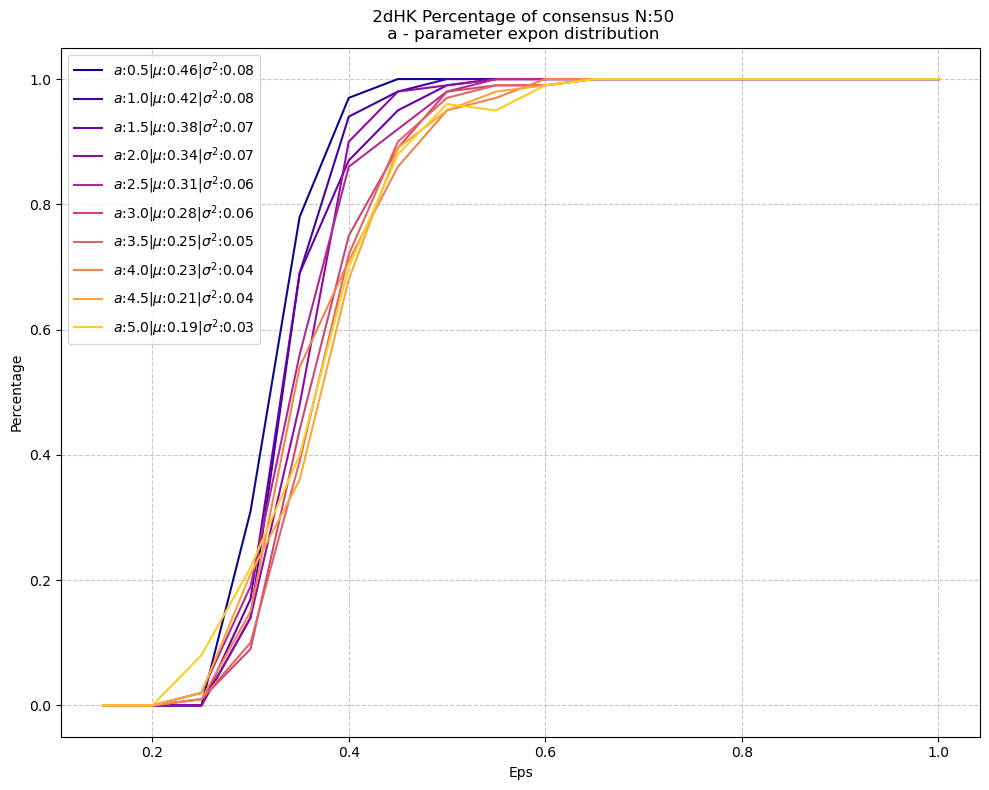

In [69]:
plt.figure(figsize=(10, 8))

cmap = mp.cm.get_cmap("plasma")
norm=plt.Normalize(vmin=min(params_array), vmax=max(params_array)+0.5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)

# Plot lines for each beta value
for i in range (len(params_array)):
    alpha = params_array[i]
    df = consensus_data.query('alpha==@alpha and N == @N')
    color=np.array(cmap(norm(alpha)))
    E, sigma = expon_distrib_a2Esigma(alpha)
    plt.plot(df['eps'], df['consensus_probabity']/df['simulation_count'], label=f'$a$:{round(alpha,2)}|$\mu$:{E:0.2f}|$\sigma^2$:{sigma:.2f}', c=color )

# plt.plot(unif_data['eps'], unif_data['consensus_probabity']/unif_data['simulation_count'], "--g",linewidth=2, label=f'uniform' )


# Adding the HK_sample line (you'll need to adjust this based on your actual data)
plt.title(f' 2dHK Percentage of consensus N:{N}\n a - parameter expon distribution')
plt.xlabel('Eps')
plt.ylabel('Percentage')
plt.legend()
# Add a grid
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [67]:
consensus_data.to_csv('expon_distib_consensus_data.csv',sep=";", index=False)